### Overview

Business Analytics teams reach out to the central data hub team to enable their access. Access enablement can take long time as the data hub team needs to coordinate access enablement with multiple teams to ensure just enough data access is enabled for the requestor. keeping duration, security and senstivity in mind. Why agents? -- Agents can scan data inventory, gather inputs from relevant stakeholders and prepare plan for execution for data hub team to enable correct access. What you created -- The workflow is a sequential loop process where agent seeks complete requirements from requestor, necessary approvals from data owners and security implementations from the subject matter experts and then prepare a plan for access activation for the data hub team

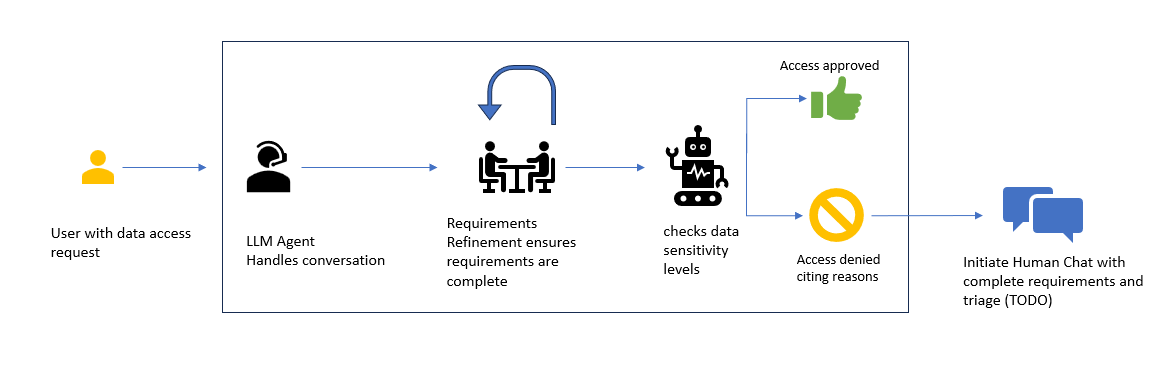
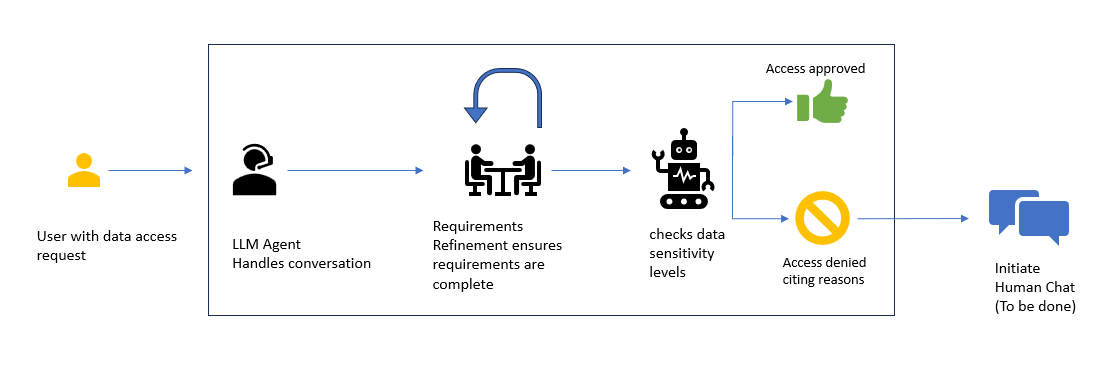

### Imports

In [1]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )
from google.adk.agents import Agent, SequentialAgent, ParallelAgent, LoopAgent, LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.tools import AgentTool, FunctionTool, google_search
from google.genai import types
from google.adk.tools import load_memory, preload_memory
from google.adk.sessions import DatabaseSessionService
from google.adk.tools.tool_context import ToolContext
from google.genai import types
from google.adk.runners import Runner
from google.adk.apps.app import App, EventsCompactionConfig

print("✅ ADK components imported successfully.")

✅ Gemini API key setup complete.
✅ ADK components imported successfully.


### Function Definitions

In [2]:
async def run_session(
    runner_instance: Runner,
    user_queries: list[str] | str = None,
    session_name: str = "default",
):
    print(f"\n ### Session: {session_name}")

    # Get app name from the Runner
    app_name = runner_instance.app_name

    # Attempt to create a new session or retrieve an existing one
    try:
        session = await session_service.create_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )
    except:
        session = await session_service.get_session(
            app_name=app_name, user_id=USER_ID, session_id=session_name
        )

    # Process queries if provided
    if user_queries:
        # Convert single query to list for uniform processing
        if type(user_queries) == str:
            user_queries = [user_queries]

        # Process each query in the list sequentially
        for query in user_queries:
            print(f"\nUser > {query}")

            # Convert the query string to the ADK Content format
            query = types.Content(role="user", parts=[types.Part(text=query)])

            # Stream the agent's response asynchronously
            async for event in runner_instance.run_async(
                user_id=USER_ID, session_id=session.id, new_message=query
            ):
                # Check if the event contains valid content
                if event.content and event.content.parts:
                    # Filter out empty or "None" responses before printing
                    if (
                        event.content.parts[0].text != "None"
                        and event.content.parts[0].text
                    ):
                        print(f"{MODEL_NAME} > ", event.content.parts[0].text)
    else:
        print("No queries!")


print("✅ Helper functions defined.")

✅ Helper functions defined.


In [3]:
retry_config=types.HttpRetryOptions(
    attempts=5,  # Maximum retry attempts
    exp_base=7,  # Delay multiplier
    initial_delay=1,
    http_status_codes=[429, 500, 503, 504], # Retry on these HTTP errors
)

### App Definitions

#### Adding SQL DB Memory for conversations

In [4]:
APP_NAME = "EnterpiseDataAccessAgent"  # Application
USER_ID = "default"  # User
SESSION = "default"  # Session

MODEL_NAME = "gemini-2.5-flash-lite"

# Step 1: Create the same agent (notice we use LlmAgent this time)
chatbot_agent = LlmAgent(
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    name="text_chat_bot",
    description="""You are a specialized requirements gathering agent for data access. Your only job is to gather the
    following information from the users.
    
    1. list of tables 
    2. name of the subject matter expert
    3. name of the data owner    
    4. Business justification for data access

    Ask the user for any inputs required on the above information.    
    """,
)

# Step 2: Switch to DatabaseSessionService
# SQLite database will be created automatically
db_url = "sqlite:///my_agent_data.db"  # Local SQLite file
session_service = DatabaseSessionService(db_url=db_url)

# Step 3: Create a new runner with persistent storage
runner = Runner(agent=chatbot_agent, app_name=APP_NAME, session_service=session_service)

print("✅ Upgraded to persistent sessions!")
print(f"   - Database: my_agent_data.db")
print(f"   - Sessions will survive restarts!")

✅ Upgraded to persistent sessions!
   - Database: my_agent_data.db
   - Sessions will survive restarts!


In [5]:
# await run_session(
#     runner,
#     [
#         "I want to access data from SAP (MARA, MAKT) for Master Data validation purpose. The data owner is john doe and subject matter expert is mary jane.",
#         "I want to use this data for Master data validation."
#     ],
#     "stateful-agentic-session",
# )

### Creating Agents

In [6]:
# This agent runs ONCE at the beginning to create the first draft.
initial_requirements_agent = Agent(
    name="InitialRequirementsAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Based on the user's prompt, write the first draft of the requirements (around 100-150 words).
    Expected Output Format:
    1. list of tables 
    2. name of the subject matter expert
    3. name of the data owner    
    4. Business justification for data access
    
    Output only the requirements text, with no introduction or explanation.""",
    output_key="current_requirements",  # Stores the first draft in the state.
)

print("✅ initial_writer_agent created.")

✅ initial_writer_agent created.


In [7]:
# Requirements Gathering Agent: Its job is to use the interact with the user and gather necessary inputs such as number of tables, name for the SME, name for the system owner among other details.
requirements_agent = Agent(
    name="requirements_agent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""You are a specialized requirements gathering agent for data access. Your only job is to gather the
    following information from the users.
    
    1. list of tables 
    2. name of the subject matter expert
    3. name of the data owner    
    4. Business justification for data access

    Ask the user for any inputs required on the above information.
    
    """,    
    output_key="current_requirements",  # The result of this agent will be stored in the session state with this key.
)

print("✅ research_agent created.")

✅ research_agent created.


In [8]:
# This is the function that the RefinerAgent will call to exit the loop.
def exit_loop():
    """Call this function ONLY when the critique is 'APPROVED', indicating the requirements are finished and no more changes are needed."""
    return {"status": "approved", "message": "Requirements approved. Exiting refinement loop."}


print("✅ exit_loop function created.")

✅ exit_loop function created.


In [9]:
# This agent's only job is to provide feedback or the approval signal. It has no tools.
requirements_critic_agent = Agent(
    name="RequirementCriticAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""You are a user requirements critic. Review the requirements provided below.
    Requirements: {current_requirements}

    Instructions: DONOT create requirements by yourself. Requirements should contain list of tables, name of the subject matter expert, name of the data owner and business justification for access.
    
    Evaluate the requirements
    - If the requirements are well-written and complete, you MUST respond with the exact phrase: "APPROVED"
    - Otherwise, provide 2-3 specific, actionable suggestions to recieve these inputs from the user.""",
    output_key="critique",  # Stores the feedback in the state.
)

print("✅ critic_agent created.")

✅ critic_agent created.


In [10]:
# This agent refines the story based on critique OR calls the exit_loop function.
requirements_refiner_agent = Agent(
    name="RequirementsRefinerAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""You are a requirements refiner. You have a requirements draft and critique.
    
    Requirements Draft: {current_requirements}
    Critique: {critique}
    
    Your task is to analyze the critique.
    - IF the critique is EXACTLY "APPROVED", you MUST call the `exit_loop` function and nothing else.
    - OTHERWISE, recieve the inputs from the user and rewrite the requirements draft to fully incorporate the feedback from the critique.""",
    output_key="current_requirments",  # It overwrites the story with the new, refined version.
    tools=[
        FunctionTool(exit_loop)
    ],  # The tool is now correctly initialized with the function reference.
)

print("✅ refiner_agent created.")

✅ refiner_agent created.


### Custom Tools Approval Logic

In [13]:
def get_approval_for_tables(table_list: str) -> dict:
    """Looks up and returns the exchange rate between two currencies.

    Args:
        table_list: Comma separated list of tables where user requires access                      
        

    Returns:
        Dictionary with status and approval date.
        Success: {"status": "success", "approval": True}
        Error: {"status": "error", "error_message": "Cannot approve access"}
    """

    # Static data simulating a live exchange rate API
    # In production, this would call something like: requests.get("api.exchangerates.com")
    approval = not 'ACDOCA' in table_list

    if approval is not None:
        return {"status": "success", "approval": approval, "message": "Access is approved" if approval else "Access is denied"}   
    else:
        return {
            "status": "error",
            "error_message": f"Cannot approve access to ACDOCA as it contains financial sensitive data",
        }


print("✅ Access Approval function created")
print(f"💱 Test: {get_approval_for_tables('ACDOCA, VBAP')}")
print(f"💱 Test: {get_approval_for_tables('VBRK, VBAP')}")

✅ Access Approval function created
💱 Test: {'status': 'success', 'approval': False, 'message': 'Access is denied'}
💱 Test: {'status': 'success', 'approval': True, 'message': 'Access is approved'}


In [14]:
# Currency agent with custom function tools
access_approver_agent = LlmAgent(
    name="access_approver",
    model=Gemini(model="gemini-2.5-flash-lite", retry_options=retry_config),
    instruction="""You are a data access approver assistant.

    For access approval requests:
    1. Use `get_approval_for_tables()` to validate if access can be approved    
    4. In case status is success and approval is True
    5. As an output, state the message value        

    If any tool returns status "error", explain the issue to the user clearly.
    """,
    tools=[get_approval_for_tables],
)

print("✅ Access approver_agent created with custom function tools")
print("🔧 Available tools:")
print("  • get_approval_for_tables - Returns approval for requested tables ")

✅ Access approver_agent created with custom function tools
🔧 Available tools:
  • get_approval_for_tables - Returns approval for requested tables 


### Agent Refinement loop and Approval process

In [15]:
# The LoopAgent contains the agents that will run repeatedly: Critic -> Refiner.
requirements_refinement_loop = LoopAgent(
    name="RequirementsRefinementLoop",
    sub_agents=[requirements_critic_agent, requirements_refiner_agent],
    max_iterations=3,  # Prevents infinite loops
)

# The root agent is a SequentialAgent that defines the overall workflow: Initial Write -> Refinement Loop.
root_agent = SequentialAgent(
    name="RequirementsPipeline",
    sub_agents=[chatbot_agent,initial_requirements_agent, requirements_refinement_loop,access_approver_agent],
)

print("✅ Loop and Sequential Agents created.")

✅ Loop and Sequential Agents created.


### Compaction Logic for Long Conversations|

In [16]:
# Re-define our app with Events Compaction enabled
requirements_app_compacting = App(
    name="requirements_app_compacting",
    root_agent=root_agent,
    # This is the new part!
    events_compaction_config=EventsCompactionConfig(
        compaction_interval=3,  # Trigger compaction every 3 invocations
        overlap_size=1,  # Keep 1 previous turn for context
    ),
)

db_url = "sqlite:///my_agent_data.db"  # Local SQLite file
session_service = DatabaseSessionService(db_url=db_url)

# Create a new runner for our upgraded app
research_runner_compacting = Runner(
    app=requirements_app_compacting, session_service=session_service
)


print("✅ Research App upgraded with Events Compaction!")

✅ Research App upgraded with Events Compaction!


/tmp/ipykernel_47/543700575.py:6: UserWarning: [EXPERIMENTAL] EventsCompactionConfig: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  events_compaction_config=EventsCompactionConfig(


In [18]:
# # Get the final session state
# await run_session(
#     research_runner_compacting,
#     "I want to access data from SAP (MARA, MAKT) for Master Data validation purpose. The data owner is john doe and subject matter expert is mary jane.",
#     "compaction_demo",
# )

# final_session = await session_service.get_session(
#     app_name=research_runner_compacting.app_name,
#     user_id=USER_ID,
#     session_id="compaction_demo",
# )

# print("--- Searching for Compaction Summary Event ---")
# found_summary = False
# for event in final_session.events:
#     # Compaction events have a 'compaction' attribute
#     if event.actions and event.actions.compaction:
#         print("\n✅ SUCCESS! Found the Compaction Event:")
#         print(f"  Author: {event.author}")
#         print(f"\n Compacted information: {event}")
#         found_summary = True
#         break

# if not found_summary:
#     print(
#         "\n❌ No compaction event found. Try increasing the number of turns in the demo."
#     )

In [19]:
await run_session(
    research_runner_compacting,
    "I want to access data from SAP (MARA, MAKT) for Master Data validation purpose. The data owner is john doe and subject matter expert is mary jane.",
    "data_access_request_demo_1",
)


 ### Session: data_access_request_demo_1

User > I want to access data from SAP (MARA, MAKT) for Master Data validation purpose. The data owner is john doe and subject matter expert is mary jane.
gemini-2.5-flash-lite >  Thank you for providing the information. To confirm, could you please elaborate on the business justification for accessing this data? What specific business goals or processes will this master data validation support?
gemini-2.5-flash-lite >  1. Tables: MARA, MAKT
2. Subject Matter Expert: Mary Jane
3. Data Owner: John Doe
4. Business Justification: Access to MARA (Material Master) and MAKT (Material Description) tables is required for a master data validation initiative. This validation will ensure the accuracy, completeness, and consistency of material master data. The improved data quality will support downstream processes such as accurate inventory management, streamlined procurement, enhanced sales reporting, and more reliable financial analysis, ultimately lead

gemini-2.5-flash-lite >  APPROVED


gemini-2.5-flash-lite >  APPROVED


gemini-2.5-flash-lite >  
Access is approved.


In [21]:
await run_session(
    research_runner_compacting,
    "I want to access data from SAP (MARA, MAKT, ACDOCA) for Master Data validation purpose. The data owner is john doe and subject matter expert is mary jane.",
    "data_access_request_demo_2",
)


 ### Session: data_access_request_demo_2

User > I want to access data from SAP (MARA, MAKT, ACDOCA) for Master Data validation purpose. The data owner is john doe and subject matter expert is mary jane.
gemini-2.5-flash-lite >  Thank you for providing the business justification.

Based on the information you've provided, the access request for MARA, MAKT, and ACDOCA has been denied.
gemini-2.5-flash-lite >  1. Tables: MARA, MAKT, ACDOCA
2. Subject Matter Expert: Mary Jane
3. Data Owner: John Doe
4. Business Justification for Data Access: To perform comprehensive master data validation. This includes checking MARA for duplicate material numbers, mandatory field completeness, consistent description formatting, and valid material groups. For MAKT, validation will ensure description consistency across languages, completeness for active materials, and accurate language keys. ACDOCA validation will verify G/L account existence, correct cost/profit center and segment data, balanced document